In [1]:
from IPython.core.display import display, HTML
import warnings
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))

# Goal

The goal of this notebook is to demonstrate the use of the Optimizer Evaluation Tools.

## Optimizer evaluation purpose

The goal of optimizer evaluation is to learn how to best match an optimizer configuration to an optimization problem.

## Optimizer evaluation strategy

Broadly, the optimizer evaluation strategy hinges on characterizing the optimizers' performance on a variety of optimization problems, under a variety of configurations. This should allow us to:
* find the strengths and limitations of the various optimizer configurations,
* discard the dominated configurations,
* ultimately match optimizer configurations with the problem.

Note: No absolute scale of optimzier performance seems to have garnered consensus in the community. Thus, in this exercise we will compare the optimizers with each other. We can also compare them to some published results, though it might be good to replicate them first.

A common way to compare multiple optimizers is to rank them for each problem given a particular budget (usually in terms of number of evaluations, though if we assume that the function is cheap to compute, optimizer resource consumption might be more relevant). Then we can report average rank across problems to compare the optimizers. Or we can do a matrix for each benchmark problem which optimizer dominates which.


### Optimizer performance characteristics

We aim to evaluate the following aspects of the optimizers' performance:
* convergence - is the optimizer finding the optima, More formally, can the optimizer get within epsilon of the known optimum at all?
* rate of convergence - how quickly is the optimizer finding the optima?
* trajectory of convergence - is the optimizer improving rapidly at first, and then reaching a plateau, is it climbing steadily, or does it stagnate for a long time, before finally shooting up?
* surrogate model goodness of fit - how well do the models fit the training data, validation data (out of bag samples), test data (observations gathered after the model was fit), random test data (random observations gathered after the model was fit). 
* computational cost - for now we can use the Tracer to capture runtime information, down the road we should monitor CPU, and memory utilization too.

### What to measure

ML metrics:
* Convergence of the entire optimizer on synthetic and real data.
* Models' goodness of fit on synthetic and real data, in both on both guided and unguided observations.
* Utility function optimizers' performance on synthetic data.
We shall measure and plot all of the above metrics as a function of the number of observations that the optimzier has been fit on.


Resource consumption metrics:
* Optimization Trace

Additionally, we can serialize the models over time to later inspect how they evolve. And in case something goes wrong, we have snapshots leading up to the failure.


<hr>

##### Definition of optimum
Various definitions of optimum are possible, and we have built consensus that the user should choose a definition suitable for their purpose. Here are some options:
1. Best observation - simplest, but can be deceptive in presence of noise. 
2. Observations with the highest:
    1. predicted mean performance
    2. upper confidence bound on performance
    3. lower confidence bound on performance
3. Speculative optima - return configurations predicted by the surrogate model but not necessarily tested:
    1. maximum predicted mean
    2. maximum predicted upper confidence bound
    3. maximum predicted lower confidence bound
        
Once we graduate to multi-objective optimization, we will need to build pareto frontiers from the above.
<hr>


### Selecting the optimizer configuration

The ability of an optimizer to converge on an optimum is our fundamental requirement. From between the optimizers that can converge we can break ties using secondary criteria: rate of convergence, goodness of fit, computational complexity of the optimizer.

### Troubleshooting the optimizers

For the optimizers that do not converge, this framework should illuminate their modes of failure:
* Is the model not fitting the data well?
* Is the model fitting the data, but the exposed parameters don't affect performance, or is there too much noise?
* If the model has strong goodness of fit, and performance is sensitive to the parameters, is the utility function optimizer up to the job? 
* Are we using the right utility function?

In [2]:
import datetime
import os

import mlos.global_values as global_values
from mlos.Tracer import traced, Tracer

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="OptimizerEvaluation", thread_id=0)

# Let's prepare a directory for evaluation reports.
#
optimizer_results_root_dir = os.path.abspath(os.path.join(os.getcwd(), "..","..", "temp"))
if not os.path.exists(optimizer_results_root_dir):
    os.mkdir(optimizer_results_root_dir)
optimizer_results_folder_name = f"optimization_started_on_{datetime.datetime.now().strftime('%Y_%m_%d_at_%H_%M_%S')}"
optimizer_results_dir = os.path.abspath(os.path.join(optimizer_results_root_dir, optimizer_results_folder_name))

if not os.path.exists(optimizer_results_dir):
    os.mkdir(optimizer_results_dir)

## Objective Function
Let's create an objective function taht we will be configuring.

In [3]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory

objective_function_config = objective_function_config_store.get_config_by_name('5_mutually_exclusive_polynomials')
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.input_domain_min = -20
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.input_domain_width = 40
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.coefficient_domain_min = 100
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.coefficient_domain_width = 10
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.include_noise = False
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.noice_coefficient_of_variation = 0.0


objective_function_config = objective_function_config_store.get_config_by_name('three_level_quadratic')
print("Objective function config:")
print(objective_function_config.to_json(indent=2))

Objective function config:
{
  "implementation": "ThreeLevelQuadratic"
}


In [4]:
objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)
print(objective_function.parameter_space)

  Name: three_level_quadratic_config
  Dimensions:
    vertex_height: {low, 5, 15}

  IF vertex_height IN {low} THEN (
    Name: low_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {15} THEN (
    Name: high_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {5} THEN (
    Name: medium_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )


## Optimizer Configuration
Let's use the default optimizer configuration.

In [5]:
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store

optimizer_config = bayesian_optimizer_config_store.default
print(optimizer_config)

{
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 0,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.min_samples_spli

## Optimizer Evaluation
Let's configure the optimizer evaluator.

In [6]:
from mlos.OptimizerEvaluationTools.OptimizerEvaluator import OptimizerEvaluator, optimizer_evaluator_config_store

evaluator_config = optimizer_evaluator_config_store.default
evaluator_config.num_iterations = 1000
evaluator_config.evaluation_frequency = 50

print(evaluator_config)

{
  "num_iterations": 1000,
  "evaluation_frequency": 50,
  "include_pickled_optimizer_in_report": true,
  "include_pickled_objective_function_in_report": true,
  "report_regression_model_goodness_of_fit": true,
  "report_optima_over_time": true,
  "include_execution_trace_in_report": true
}


In [7]:
# Let's run the evaluation a bunch of times. We can do it in parallel to save a bit of time.
#
import concurrent.futures

num_runs = 8
max_workers = 8


evaluation_reports = []
with traced("parallel_evaluations"), concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    outstanding_futures = set()
    
    for i in range(num_runs):
        evaluator = OptimizerEvaluator(
            optimizer_evaluator_config=evaluator_config,
            optimizer_config=optimizer_config,
            objective_function=objective_function
        )
        future = executor.submit(evaluator.evaluate_optimizer)
        outstanding_futures.add(future)
    
    done_futures, outstanding_futures = concurrent.futures.wait(outstanding_futures, return_when=concurrent.futures.ALL_COMPLETED)
    
    for future in done_futures:
        optimizer_evaluation_report = future.result()
        evaluation_reports.append(optimizer_evaluation_report)
        global_values.tracer.trace_events.extend(optimizer_evaluation_report.execution_trace)
    


10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/31/2020 01:46:12 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

In [8]:
evaluation_trace_file_path = os.path.join(optimizer_results_dir, "parallel_evaluation.json")
print(evaluation_trace_file_path)
global_values.tracer.dump_trace_to_file(output_file_path=evaluation_trace_file_path)

E:\code\github_mlos\temp\optimization_started_on_2020_10_30_at_18_46_11\parallel_evaluation.json


## Plotting Results
Let's plot the various optima over time.

C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


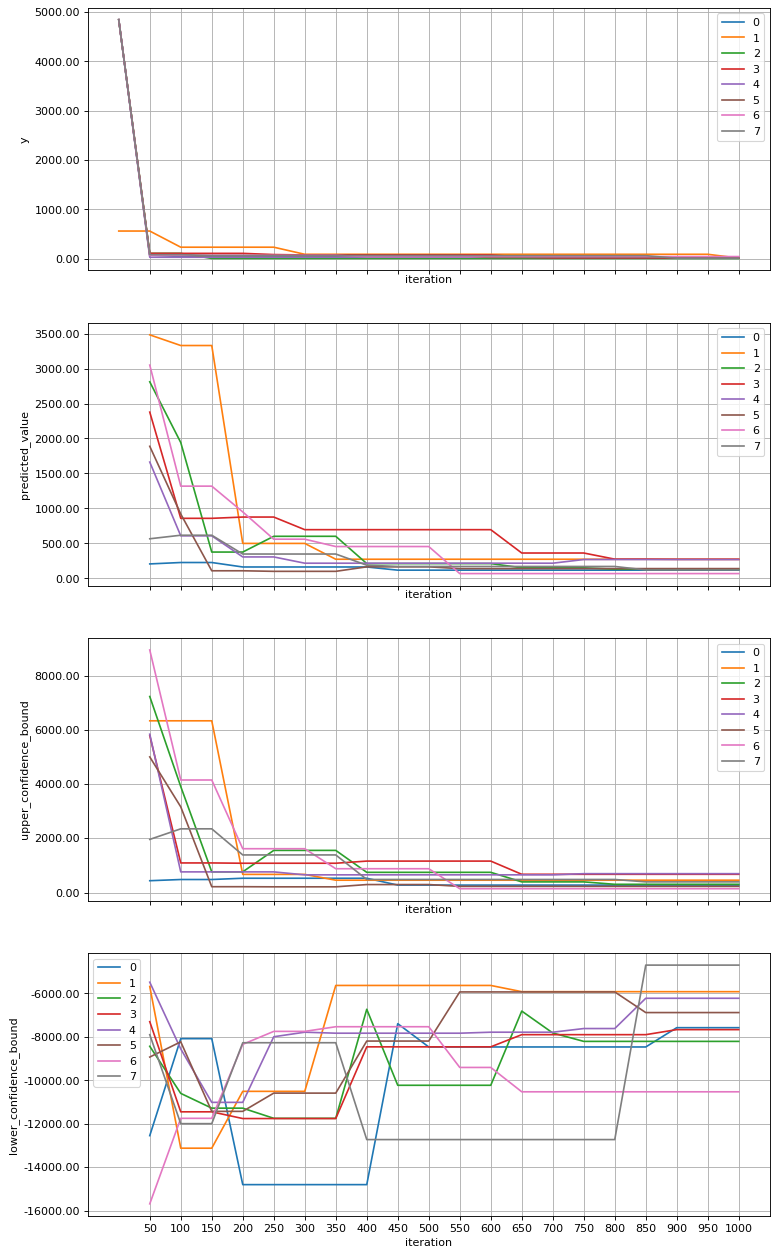

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from mlos.Optimizers.OptimumDefinition import OptimumDefinition

fig, axs = plt.subplots(4, figsize=(11, 20), dpi=80, sharex=True)

optimum_definition_names = [
    OptimumDefinition.BEST_OBSERVATION.value,
    OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG.value,
    f"{OptimumDefinition.UPPER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG.value}_99",
    f"{OptimumDefinition.LOWER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG.value}_99"
]
optimum_column_names = ['y', 'predicted_value', 'upper_confidence_bound', 'lower_confidence_bound']

for i, (optimum_definition_name, optimum_column_name) in enumerate(zip(optimum_definition_names, optimum_column_names)):
    for j, report in enumerate(evaluation_reports):
        optimum_df = report.optima_over_time[optimum_definition_name].get_dataframe()
        if len(optimum_df.index) > 0:
            axs[i].plot(optimum_df['iteration'], optimum_df[optimum_column_name], label=j)
            axs[i].set_xticks(optimum_df['iteration'])
        
    axs[i].set_ylabel(optimum_column_name)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].grid(True)
    axs[i].set_xlabel('iteration')
    axs[i].legend()  
fig.show()

C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


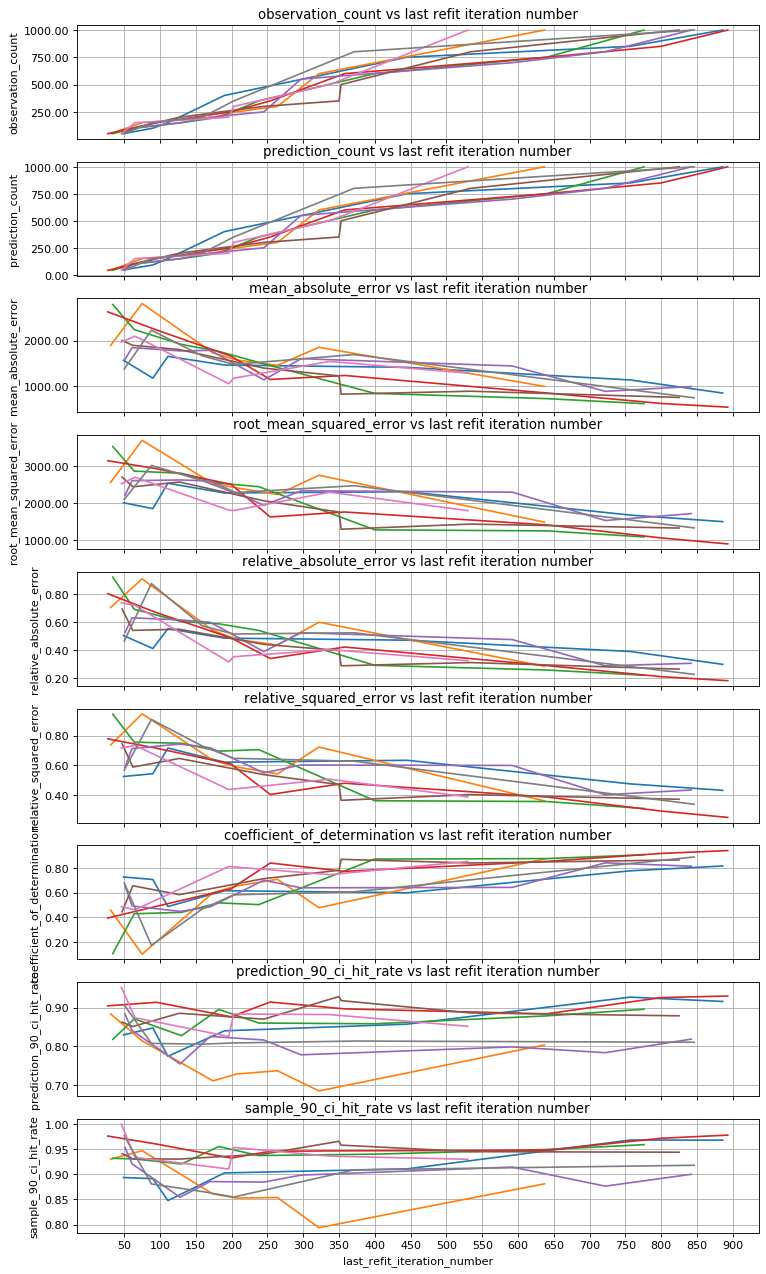

In [10]:
# Let's see if we can plot goodness of fit.
#
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import GoodnessOfFitMetrics, DataSetType

first_gof_df = evaluation_reports[0].regression_model_goodness_of_fit_state.get_goodness_of_fit_dataframe(DataSetType.TRAIN)
all_gof_dfs = [report.regression_model_goodness_of_fit_state.get_goodness_of_fit_dataframe(DataSetType.TRAIN) for report in evaluation_reports]

columns_to_plot = [name for name in first_gof_df.columns.values][1:]
num_plots = len(columns_to_plot)

fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    for j, gof_df in enumerate(all_gof_dfs):
        axs[i].plot(gof_df['last_refit_iteration_number'], gof_df[column], label=j)
        
        if j == 0:
            axs[i].set_title(f"{column} vs last refit iteration number")
            axs[i].set_ylabel(column)
            axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
            axs[i].set_xticks(optimum_df['iteration'])
            axs[i].grid(True)
        if i == num_plots - 1:
            axs[i].set_xlabel('last_refit_iteration_number')
        
fig.show()

## TODO: Bayesian Optimizer Evaluation

1. Compare the number of iterations needed to reach the same optimum for the various optimizers.    
2. Progressively increase the difficulty of the optimization problems:
    1. Amount of noise.
    2. Number of dimensions.
    3. Discontinuous functions.
    4. Search spaces with more branching and nesting.
3. Better plots - the plots above are quite crowded. Can we replace them with summaries?

## TODO: Utility Function Optimizer Evaluation

This is a two-step process.
1. Evaluate these model-free optimizers on the ObjectiveFunctionBase subclasses. This should allow us to capture any bugs, and get a sense of how quickly these optimizers converge on a variety of functions.
2. Evaluate these model-free optimizers as part of the bayesian optimizer. The key difference is that the model gets refit, so the underlying function changes between optimizer invocations, but we get to use prior invocations as starting points.

3. Plot all of this :)